In [1]:
import numpy as np
import cv2
import glob
import os
import pickle
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
data_path = './data/'
const = {
    'vehicles_data' : os.path.join(data_path, 'vehicles/'),
    'non_vehicles_data' : os.path.join(data_path, 'non-vehicles/'),
    'test_images' : './test_images',
    'project_video' : './project_video.mp4',
    'test_video' : './test_video.mp4'
}

### Data Load and Exploration

In [3]:
def load_images(path):
    imgs_paths = []
    imgs = []
    
    for d in os.listdir(path):
        dir_path = os.path.join(path, d)    
        imgs_paths.extend(glob.glob(os.path.join(dir_path, '*.png')))
    
    
    for path in imgs_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    
    return np.asarray(imgs)
    
vehicle_imgs = load_images(const['vehicles_data'])   
non_vehicle_imgs = load_images(const['non_vehicles_data'])   

dataset: vechicles
number of data points: 8792
shape of each point: (64, 64, 3)
data stored in: <class 'numpy.ndarray'>
10 randomly seleted samples:


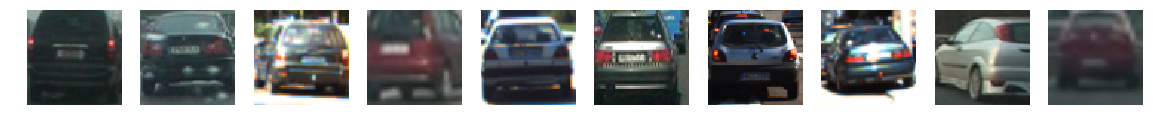

dataset: non-vechicles
number of data points: 8968
shape of each point: (64, 64, 3)
data stored in: <class 'numpy.ndarray'>
10 randomly seleted samples:


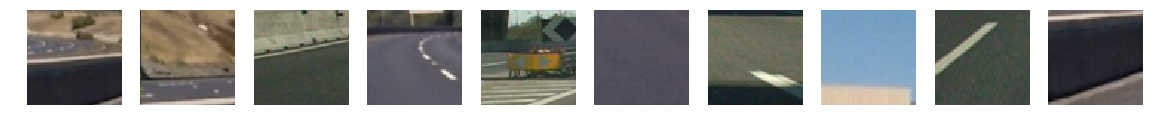

In [4]:
def exploratory_analysis(data, dataset_name=None, seed=13, sample_size=10):
    np.random.seed(seed)
    print('dataset:', dataset_name)
    print('number of data points:', data.shape[0])
    print('shape of each point:', data.shape[1:])
    print('data stored in:', type(data))
    print('{} randomly seleted samples:'.format(sample_size))
    sample_idx = np.random.randint(0, high=data.shape[0]-1, size=sample_size)
    f, ax = plt.subplots(1, sample_size, figsize=(20, 10*sample_size))
    for i, idx in enumerate(sample_idx):
        img = data[idx]
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()
    
exploratory_analysis(vehicle_imgs, dataset_name='vechicles')
exploratory_analysis(non_vehicle_imgs, dataset_name='non-vechicles')

### Feature Extraction

In [5]:
# Helper method to extract hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=transform_sqrt, visualise=vis, 
                                  feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Helper method to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Helper method to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Helper method to extract features an image
def extract_features(imgs, params): 
    color_space=params['color_space']
    spatial_size=params['spatial_size']
    hist_bins=params['hist_bins'] 
    orient=params['orient']
    pix_per_cell=params['pix_per_cell']
    cell_per_block=params['cell_per_block']
    hog_channel=params['hog_channel']
    spatial_feat=params['spatial_feat']
    hist_feat=params['hist_feat']
    hog_feat=params['hog_feat']
    
    
    features = []
    for image in imgs:
        file_features = []
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
                
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, 
                                                feature_vec=True)
            
            # Append the new feature vector to the features list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))
    return features

/udacity/jovan/CarND-Vehicle-Detection/.car-nd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


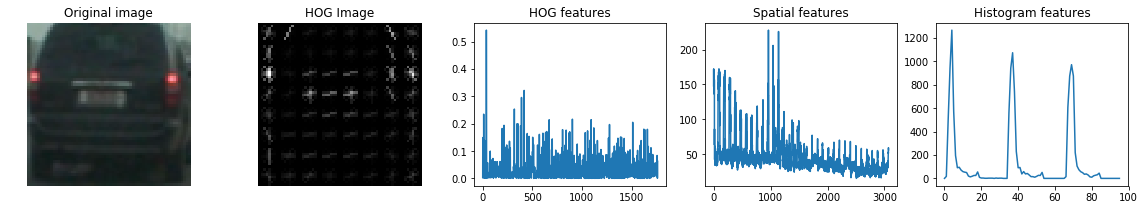

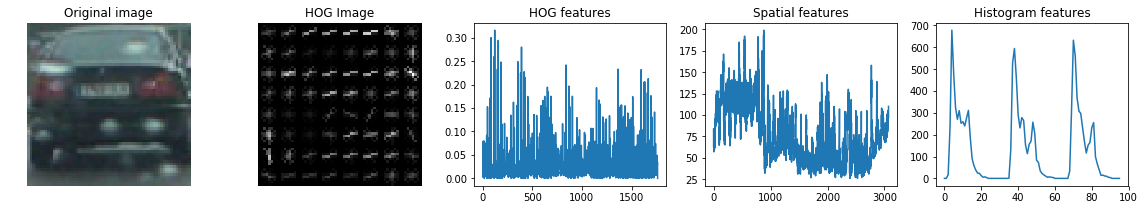

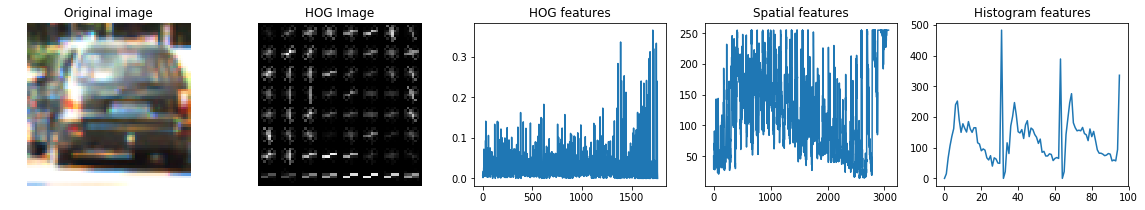

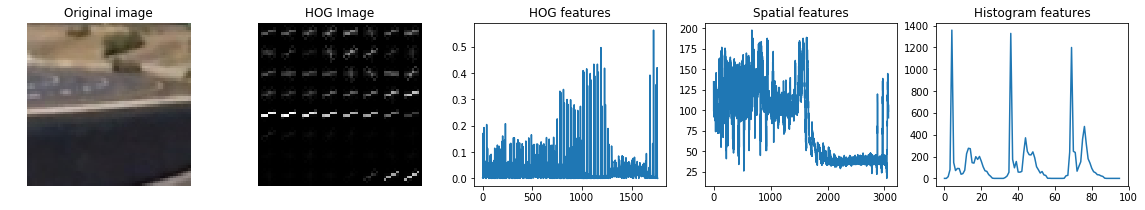

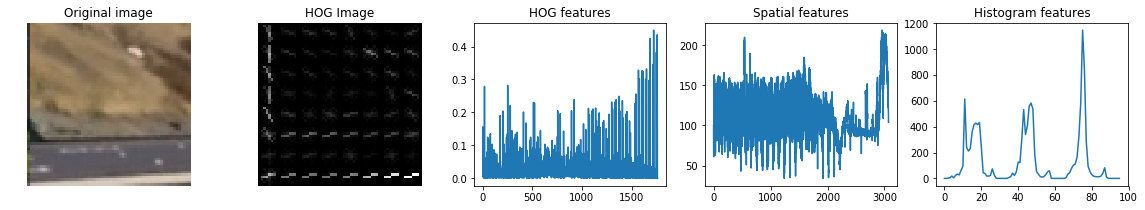

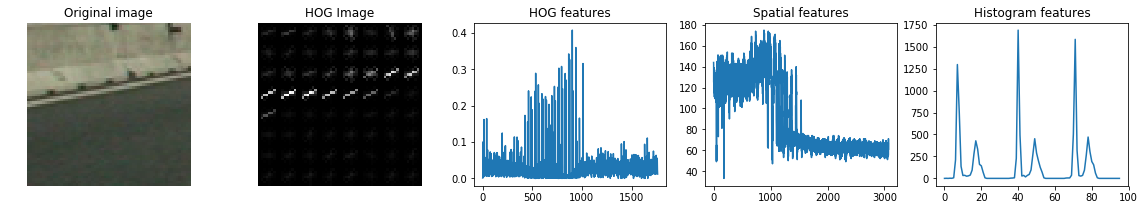

In [51]:
def visualize_features(data, sample_size=3, seed=13):
    np.random.seed(seed)
    random_idxs = np.random.randint(0, high=data.shape[0]-1, size=sample_size)
    for random_idx in random_idxs:
        img = data[random_idx]
        hog_features, hog_img = get_hog_features(img[:,:, 0], 9, 8, 2, vis=True, feature_vec=True)
        spatial_features = bin_spatial(img)
        hist_features = color_hist(img)

        fig, ax = plt.subplots(1, 5, figsize=(20, 3))
        ax[0].imshow(img)
        ax[0].set_title('Original image')
        ax[0].axis('off')

        ax[1].imshow(hog_img, cmap='gray')
        ax[1].set_title('HOG Image')
        ax[1].axis('off')

        ax[2].plot(hog_features)
        ax[2].set_title('HOG features')

        ax[3].plot(spatial_features)
        ax[3].set_title('Spatial features')

        ax[4].plot(hist_features)
        ax[4].set_title('Histogram features')
        plt.show()
    
visualize_features(vehicle_imgs)
visualize_features(non_vehicle_imgs)

### Model Training